## Setup

In [1]:
import sys
import os
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time

import numpy as np
import pandas as pd
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/pesuelogit


In [3]:
# Internal modules
from pesuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates
from pesuelogit.etl import data_curation, add_period_id

## Read spatiotemporal data

In [4]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 3)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

In [5]:
# Add period id for time-varying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [6]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

In [7]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg
count,1.013460e+06,1.009583e+06,1.013460e+06,887813.000000
mean,1.924470e+01,1.767589e+01,3.397371e-03,0.003658
std,1.982261e+01,1.909664e+01,4.350074e-03,0.004367
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,2.112700e+01,1.755400e+01,2.495627e-03,0.002784
75%,2.796200e+01,2.547600e+01,4.653995e-03,0.005216
max,6.772900e+01,7.891400e+01,7.034335e-02,0.063791


## Data processing

In [8]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [9]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.003415,0.003699,0.200169,17.946237
std,770.228931,0.004370,0.004448,0.228208,20.262676
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.002508,0.002814,0.152000,16.000000
75%,2162.450000,0.004702,0.005304,0.280000,27.340000
max,4807.000000,0.070343,0.063791,2.302000,75.652000


In [10]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.003377,0.003613,0.198494,19.650807
std,743.713869,0.004326,0.004275,0.226003,20.229134
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.002491,0.002756,0.150000,20.505000
75%,1978.000000,0.004578,0.005112,0.273000,28.117000
max,4766.000000,0.070343,0.054574,2.113000,73.943000


In [11]:
print(1-1793.271103/1865.514775, 1-17.469430/18.895705)


0.03872586428590474 0.07548143877140334


## EDA

### Observations

In [12]:
# Single period models
df.loc[(df.hour == 16) & (df.year == 2019),['counts', 'tt_avg']].describe()

,counts,tt_avg
count,2105.000000,31314.000000
mean,2191.828076,0.003848
std,821.116423,0.004593
min,3.000000,0.000000
25%,1690.000000,0.000000
50%,2082.400000,0.002906
75%,2674.000000,0.005654
max,4807.000000,0.057115


In [13]:
# TVODLULPE
df.loc[(df.hour.isin([6,7,8,15,16,17])) & (df.year == 2019),['counts', 'tt_avg']].describe()

,counts,tt_avg
count,12647.000000,186612.000000
mean,2002.699526,0.003580
std,763.098271,0.004315
min,2.000000,0.000000
25%,1519.300000,0.000000
50%,1920.000000,0.002716
75%,2410.000000,0.005113
max,4807.000000,0.057115


### Link attributes

In [14]:
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

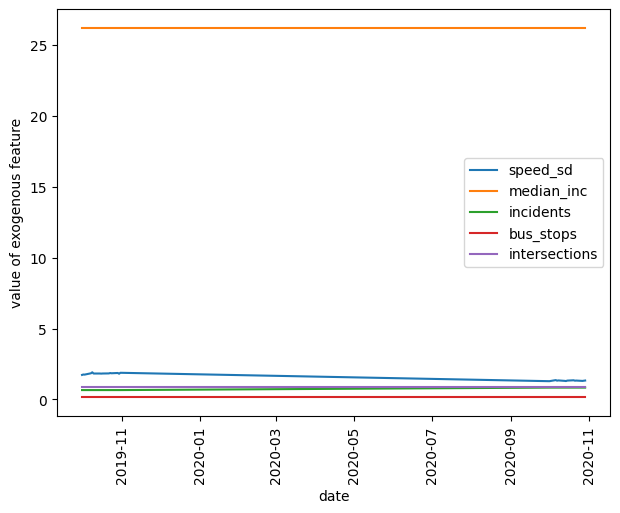

In [15]:
features_plot = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(df.groupby('date')[features_plot].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.legend(title="")
plt.ylabel("value of exogenous feature")
plt.xticks(rotation=90)
plt.show()

## Analyze single file of inrix data

In [16]:
inrix_df = pd.read_csv(f"{os.getcwd()}/input/private/inrix/2020-10-01.csv")
inrix_df['ts'] = pd.to_datetime(inrix_df['UTC Date Time'])
inrix_df['hour'] = inrix_df.ts.dt.hour
inrix_df['speed'] = inrix_df['Speed(km/hour)']*0.62137119223

In [17]:
# Select data from same time range
inrix_df = inrix_df[inrix_df.hour.isin(range(4,23))]

In [18]:
inrix_df.head()

,Date Time,Segment ID,UTC Date Time,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,Road Closure,Corridor/Region Name,ts,hour,speed
4,2020-10-01,1626763236,2020-10-01 04:00:00,52.0,48.0,42.0,0.13,90.0,100.0,0.0,0.0,F,Fresno_CA,2020-10-01 04:00:00,4,32.311302
5,2020-10-01,1626763236,2020-10-01 04:15:00,51.0,47.0,42.0,0.15,90.0,53.0,47.0,0.0,F,Fresno_CA,2020-10-01 04:15:00,4,31.689931
6,2020-10-01,1626763236,2020-10-01 04:30:00,47.0,47.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:30:00,4,29.204446
7,2020-10-01,1626763236,2020-10-01 04:45:00,45.0,45.0,42.0,0.17,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:45:00,4,27.961704
8,2020-10-01,1626763236,2020-10-01 05:00:00,48.0,48.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 05:00:00,5,29.825817


In [19]:
inrix_df.describe()

,Segment ID,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,ts,hour,speed
count,1.020604e+06,1.020300e+06,940434.000000,1.020604e+06,1.020300e+06,705930.000000,1.020300e+06,1.020300e+06,1.020300e+06,1020604,1.020604e+06,1.020300e+06
mean,7.942554e+08,5.513983e+01,54.284333,5.593239e+01,4.545113e-01,95.063257,6.403537e+01,2.810540e+01,7.859205e+00,2020-10-01 13:22:29.999999232,1.300000e+01,3.426230e+01
min,1.684284e+08,6.000000e+00,6.000000,1.000000e+01,0.000000e+00,50.000000,0.000000e+00,0.000000e+00,0.000000e+00,2020-10-01 04:00:00,4.000000e+00,3.728227e+00
25%,3.999621e+08,3.900000e+01,37.000000,4.000000e+01,1.300000e-01,90.000000,0.000000e+00,0.000000e+00,0.000000e+00,2020-10-01 08:41:15,8.000000e+00,2.423348e+01
50%,4.416791e+08,4.900000e+01,48.000000,5.000000e+01,3.500000e-01,96.670000,1.000000e+02,0.000000e+00,0.000000e+00,2020-10-01 13:22:30,1.300000e+01,3.044719e+01
75%,1.626652e+09,7.100000e+01,71.000000,7.100000e+01,6.700000e-01,100.000000,1.000000e+02,8.000000e+01,0.000000e+00,2020-10-01 18:03:45,1.800000e+01,4.411735e+01
max,1.626775e+09,1.220000e+02,122.000000,1.140000e+02,8.170000e+00,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,2020-10-01 22:45:00,2.200000e+01,7.580729e+01
std,6.271538e+08,2.324176e+01,23.336311,2.250260e+01,4.023858e-01,5.040026,4.606894e+01,4.291665e+01,2.655070e+01,NaN,5.477228e+00,1.444176e+01


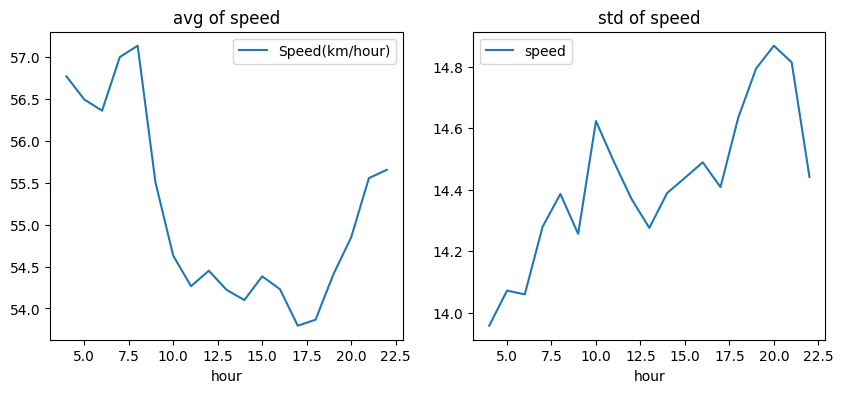

In [20]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df.groupby('hour')[['Speed(km/hour)']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df.groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');

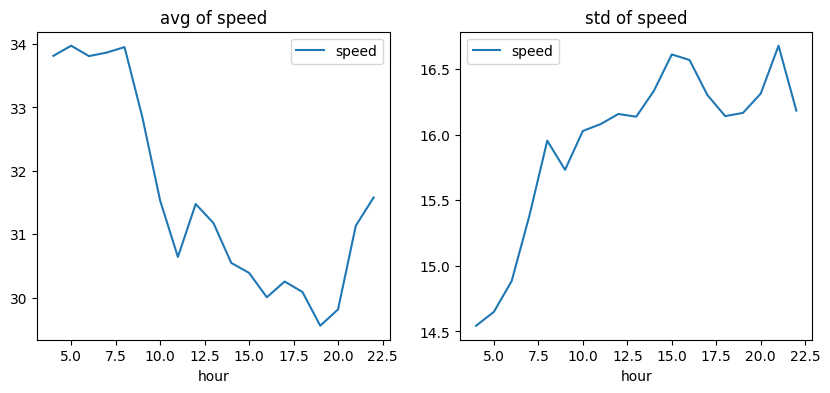

In [21]:
# Filter only data from inrix segments that were matched with the network links

fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');

## Stats by date

In [22]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [23]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Cross sectional

In [24]:
eda_df = df[df.year == 2019].copy()
#eda_df = df.copy()

eda_df['day'] = eda_df.date.dt.day#.astype(str)
eda_df['hour_id'] = eda_df['hour'].astype(str).apply(lambda x: time.strftime("%l%p", time.strptime(x,"%H")))
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

In [25]:
eda_df['hour_id'] = pd.Categorical(eda_df['hour_id'], categories = eda_df[['hour_id', 'hour']].drop_duplicates().sort_values('hour')['hour_id'], ordered = True)

eda_df['day'] = pd.Categorical(eda_df['day'], categories = eda_df[['day']].drop_duplicates().sort_values('day')['day'], ordered = True)

In [26]:
eda_df

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,intersections,date,hour,tf_inrix,year,period,period_id,tt_ff,day,hour_id
0,"(0, 1621, '0')",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,1,2019-10-01,10,0.221,2019,2019-10-01-10,4,0.003671,1,10AM
1,"(1239, 1630, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0,2019-10-01,10,0.000,2019,2019-10-01-10,4,0.000000,1,10AM
2,"(228, 192, '0')",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,0,2019-10-01,10,0.112,2019,2019-10-01-10,4,0.001859,1,10AM
3,"(1243, 1631, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0,2019-10-01,10,0.000,2019,2019-10-01-10,4,0.000000,1,10AM
4,"(1244, 1632, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0,2019-10-01,10,0.000,2019,2019-10-01-10,4,0.000000,1,10AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982086,"(805, 1205, '0')",0,NaN,1800.0,0.212,45,4.416791e+08,[],LWRLK,1853,...,0,2019-10-31,9,0.384,2019,2019-10-31-9,3,0.006397,31,9AM
982087,"(802, 1361, '0')",0,NaN,inf,0.000,99999,NaN,[],PQULK,2877,...,0,2019-10-31,9,0.000,2019,2019-10-31-9,3,0.000000,31,9AM
982088,"(993, 802, '0')",0,NaN,1800.0,0.167,25,1.685508e+08,[],LWRLK,2300,...,0,2019-10-31,9,0.167,2019,2019-10-31-9,3,0.002120,31,9AM
982089,"(800, 791, '0')",0,NaN,1800.0,0.329,45,4.498920e+08,[],LWRLK,1843,...,2,2019-10-31,9,0.595,2019,2019-10-31-9,3,0.009897,31,9AM


In [27]:
eda_df.groupby('day')[['counts']].mean().reset_index()

,day,counts
0,1,1770.335035
1,2,1746.651824
2,3,1785.115209
3,8,1747.732955
4,9,1756.834846
5,10,1793.512340
6,15,1750.339155
7,16,1760.170975
8,17,1775.411385
9,22,1738.314834


In [28]:
daily_counts = eda_df.groupby('day')[['counts']].mean().reset_index()
daily_counts['day'] = daily_counts['day'].astype(str)

daily_speed = eda_df.groupby('day')[['speed_avg']].mean().reset_index()
daily_speed['day']  = daily_speed['day'].astype(str)

daily_attributes = pd.melt(eda_df.groupby('day')[features_plot].mean().reset_index(),id_vars= ['day'])
daily_attributes['day']  = daily_attributes['day'].astype(str)

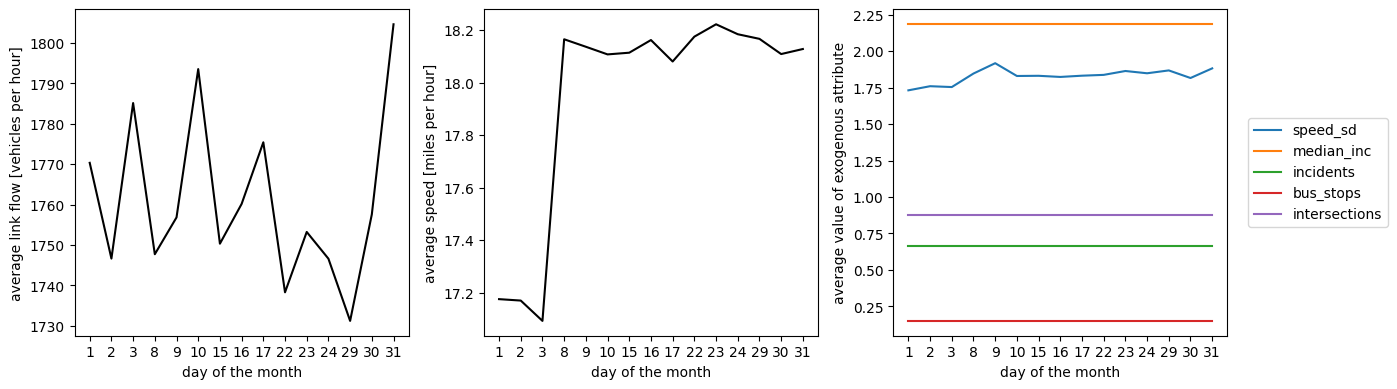

In [40]:
#formatter = matplotlib.days.dayFormatter('%d')
#locator = matplotlib.dates.DayLocator(interval = 2)

fig, axs = plt.subplots(1,3, figsize = (14,4))

sns.lineplot(x= 'day', y = 'counts', data = daily_counts, ax = axs[0], color = 'black')

sns.lineplot(x= 'day', y = 'speed_avg', data =daily_speed, ax = axs[1], color = 'black')

sns.lineplot(x= 'day', y = 'value', hue = 'variable', data =daily_attributes, ax = axs[2])

for ax in axs:
#     ax.set_xticks(np.arange(1,31,2))
#     ax.set_xticklabels(np.arange(1,31,2))
    #ax.xaxis.set_major_formatter(formatter)
    #ax.xaxis.set_major_locator(locator)
    ax.set_xlabel('day of the month')

axs[0].set_ylabel('average link flow [vehicles per hour]')
axs[1].set_ylabel('average speed [miles per hour]')

#axs[2].legend(title="", loc = 'upper right')
axs[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
axs[2].set_ylabel("average value of exogenous attribute")

#list(map(lambda x: x.set_xticklabels(x.get_xticks(), rotation=0), axs));
#fig.autofmt_xdate(rotation = 90, ha = 'center')
fig.tight_layout()

### By hour of day

In [31]:
link_keys = eda_df[(eda_df.counts>0) & (eda_df.speed_avg>0)].link_key.unique()
link_keys = link_keys[0:10]

<Axes: xlabel='hour', ylabel='speed_avg'>

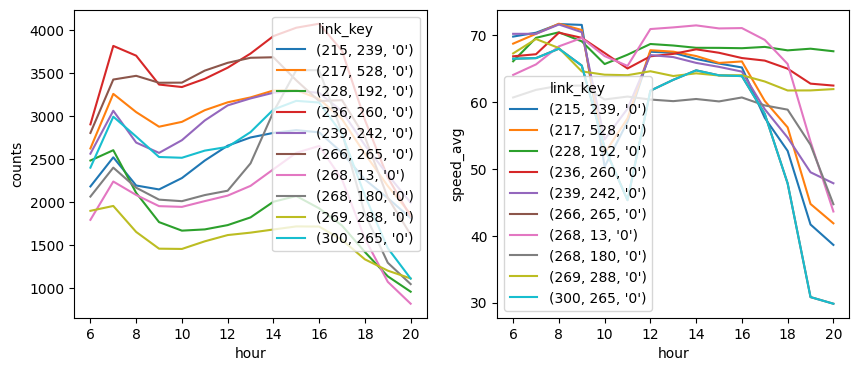

In [32]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(x= 'hour', y = 'counts', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

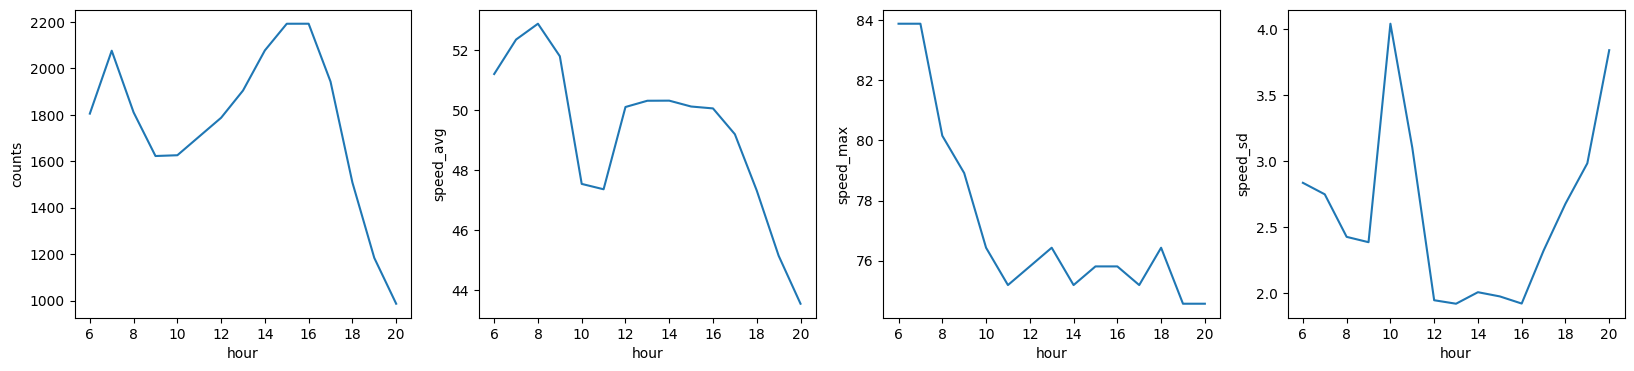

In [33]:
# Analysis for links where link counts are reported

fig, axs = plt.subplots(1,4, figsize = (20,4))

sns.lineplot(x= 'hour', y = 'counts', data =eda_df.groupby(['hour'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'hour', y = 'speed_max',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_max']].max().reset_index(),
             ax = axs[2])

sns.lineplot(x= 'hour', y = 'speed_sd',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_sd']].mean().reset_index(),
             ax = axs[3])

plt.show()

In [34]:
# Select data from 2019 only
eda_df = eda_df[eda_df.year == 2019]
eda_df['hour_id'] = pd.Categorical(eda_df['hour_id'], categories = eda_df[['hour_id', 'hour']].drop_duplicates().sort_values('hour')['hour_id'], ordered = True)

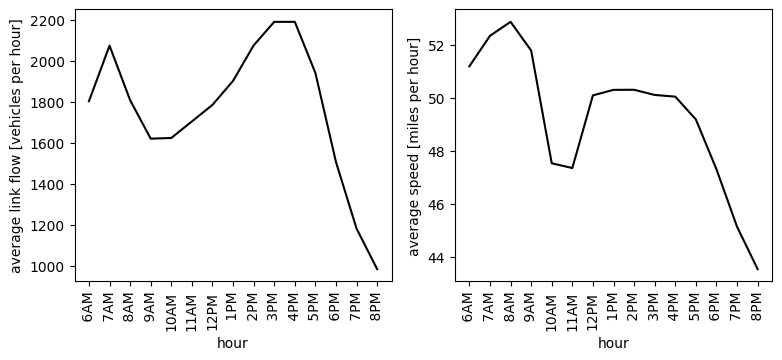

In [41]:
# Analysis for links where link counts are reported

fig, axs = plt.subplots(1,2, figsize = (9,4))

sns.lineplot(x= 'hour_id', y = 'counts', data =eda_df.groupby(['hour_id'])[['counts']].mean().reset_index(),
             ax = axs[0], color = 'black')

sns.lineplot(x= 'hour_id', y = 'speed_avg',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour_id'])[['speed_avg']].mean().reset_index(),
             ax = axs[1], color = 'black')
fig.autofmt_xdate(rotation = 90, ha = 'center')

axs[0].set_ylabel('average link flow [vehicles per hour]')
axs[1].set_ylabel('average speed [miles per hour]')
list(map(lambda x: x.set_xlabel('hour'),axs))
plt.show()